In [1]:
""" Try finding the skull by just thresholding the bone out and finding how much there is in each slice """
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append(os.path.abspath("") + "/..")

img_dir = os.path.abspath("") + "/images/"
print(img_dir)
if not os.path.exists(img_dir):
    os.makedirs(img_dir)

/home/mh19137/fish_test/localisation/images/


In [2]:
""" Read + display a jaw """
import numpy as np

img_no = 40
img = np.load(f"../tifs/{img_no}.npy")

In [3]:
""" Convert to 0-255 from float; but don't convert to int yet"""
img = (img - img.min()) / (img.max() - img.min()) * 255

(<Figure size 1200x1200 with 16 Axes>,
 array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '125'}>,
         <Axes: title={'center': '250'}>, <Axes: title={'center': '375'}>],
        [<Axes: title={'center': '500'}>, <Axes: title={'center': '625'}>,
         <Axes: title={'center': '750'}>, <Axes: title={'center': '875'}>],
        [<Axes: title={'center': '1000'}>,
         <Axes: title={'center': '1125'}>,
         <Axes: title={'center': '1250'}>,
         <Axes: title={'center': '1375'}>],
        [<Axes: title={'center': '1500'}>,
         <Axes: title={'center': '1625'}>,
         <Axes: title={'center': '1750'}>,
         <Axes: title={'center': '1875'}>]], dtype=object))

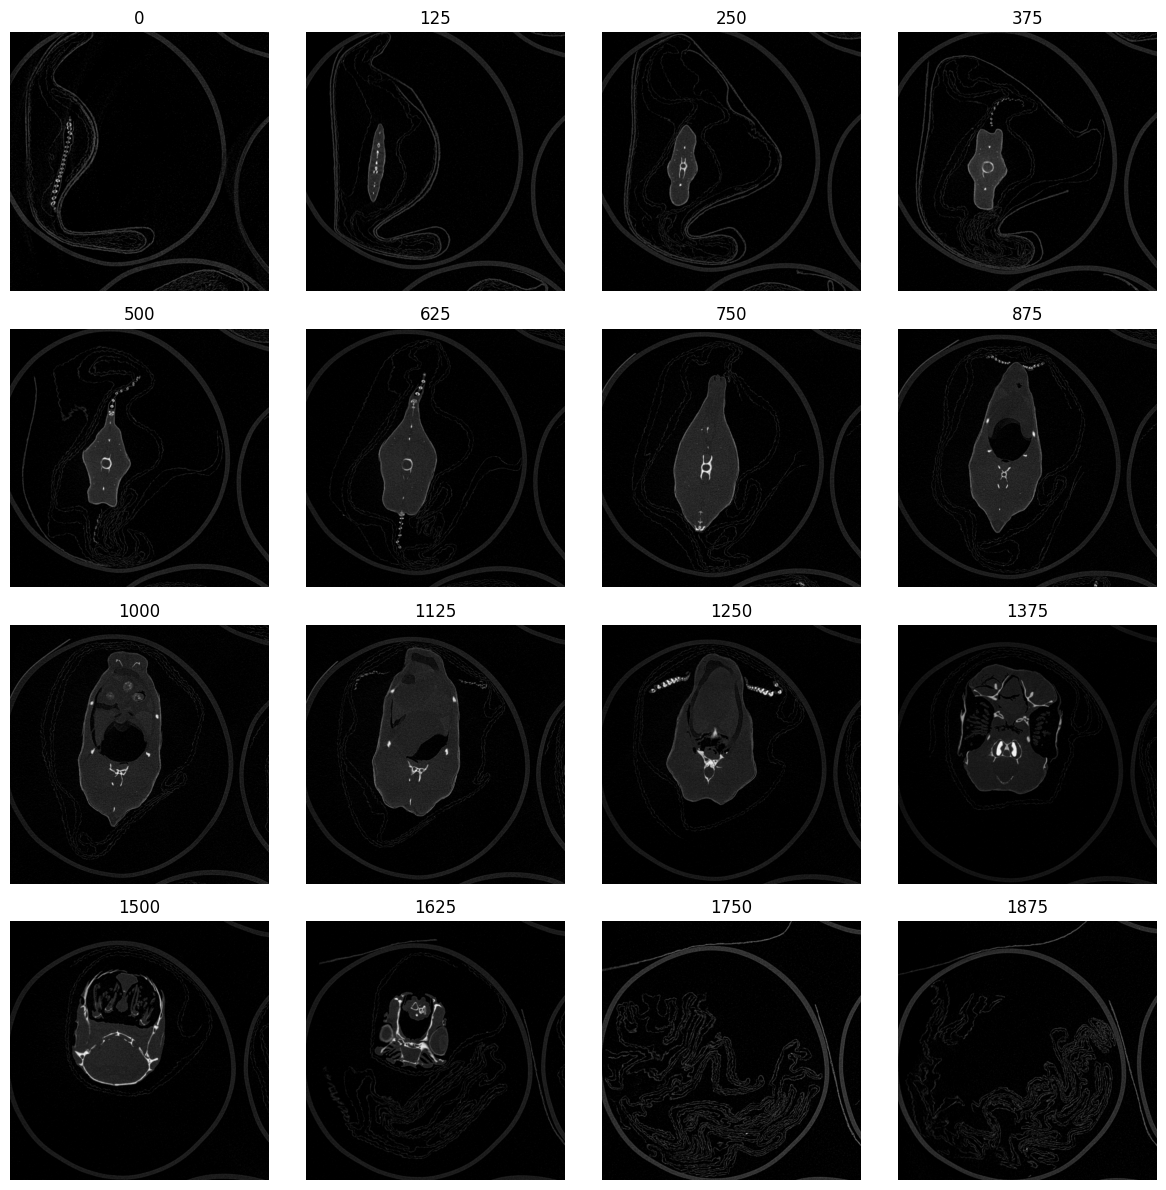

In [4]:
from dev import plot
plot.plot_arr(img)

In [5]:
""" Preprocess """
from dev import thresholding
saturated_pct = 0.35
equalised = thresholding.equalise(img, saturated_pct=saturated_pct)

(<Figure size 1200x1200 with 16 Axes>,
 array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '125'}>,
         <Axes: title={'center': '250'}>, <Axes: title={'center': '375'}>],
        [<Axes: title={'center': '500'}>, <Axes: title={'center': '625'}>,
         <Axes: title={'center': '750'}>, <Axes: title={'center': '875'}>],
        [<Axes: title={'center': '1000'}>,
         <Axes: title={'center': '1125'}>,
         <Axes: title={'center': '1250'}>,
         <Axes: title={'center': '1375'}>],
        [<Axes: title={'center': '1500'}>,
         <Axes: title={'center': '1625'}>,
         <Axes: title={'center': '1750'}>,
         <Axes: title={'center': '1875'}>]], dtype=object))

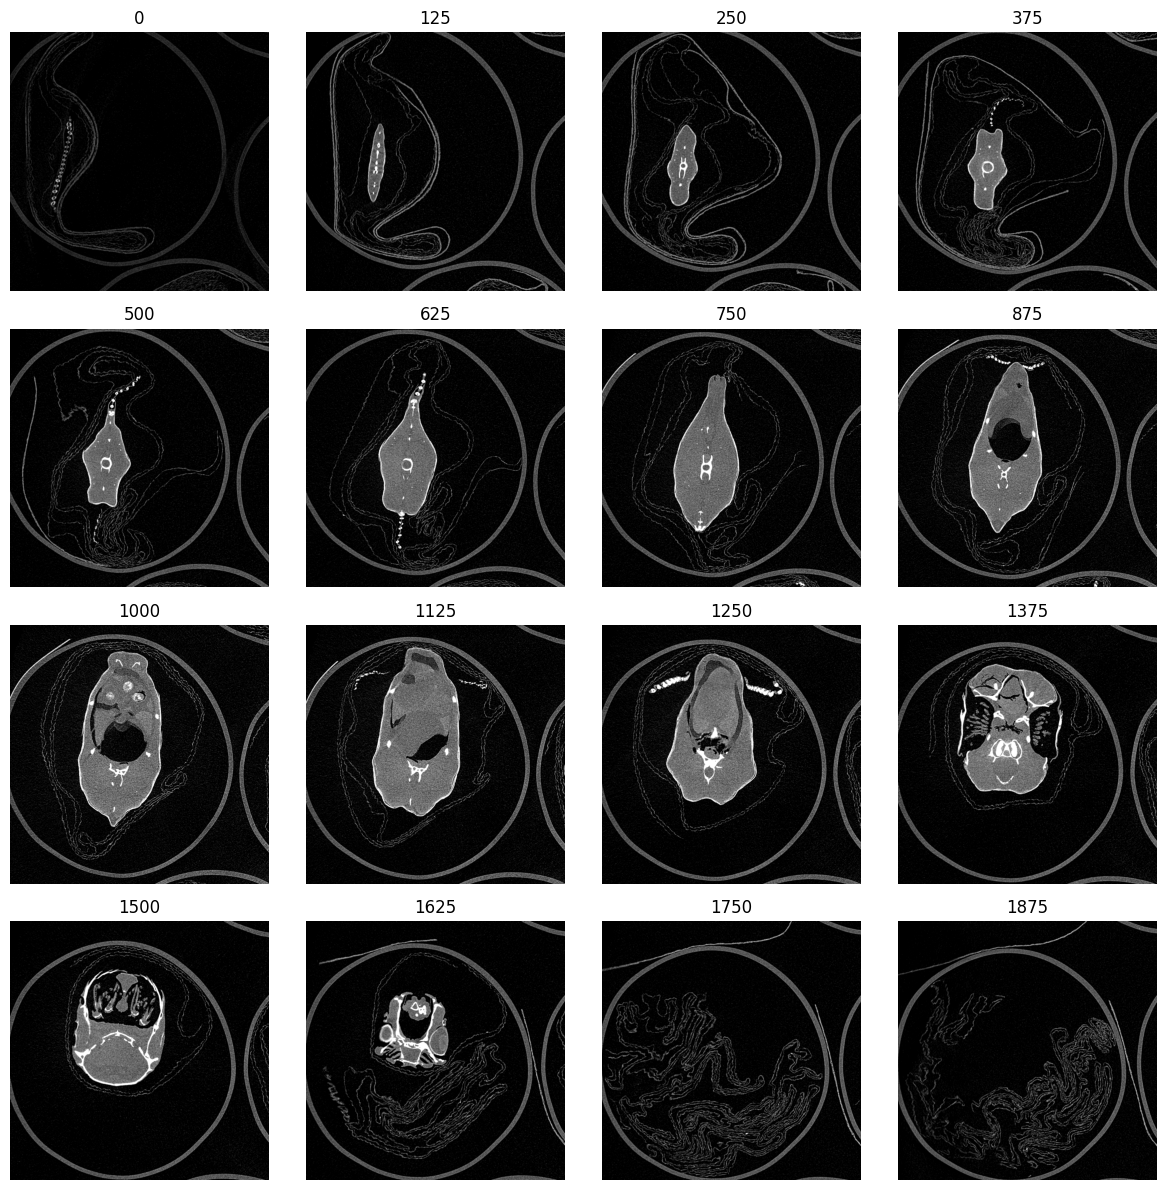

In [6]:
plot.plot_arr(equalised)

In [19]:
""" Threshold out, keeping only the brightest pixels """

threshold_pct = 0.45
value = np.quantile(equalised.flat, 1 - (threshold_pct / 100))
print(value)
len(equalised.flat)

0.9047619047619048


819200000

(<Figure size 1200x1200 with 16 Axes>,
 array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '125'}>,
         <Axes: title={'center': '250'}>, <Axes: title={'center': '375'}>],
        [<Axes: title={'center': '500'}>, <Axes: title={'center': '625'}>,
         <Axes: title={'center': '750'}>, <Axes: title={'center': '875'}>],
        [<Axes: title={'center': '1000'}>,
         <Axes: title={'center': '1125'}>,
         <Axes: title={'center': '1250'}>,
         <Axes: title={'center': '1375'}>],
        [<Axes: title={'center': '1500'}>,
         <Axes: title={'center': '1625'}>,
         <Axes: title={'center': '1750'}>,
         <Axes: title={'center': '1875'}>]], dtype=object))

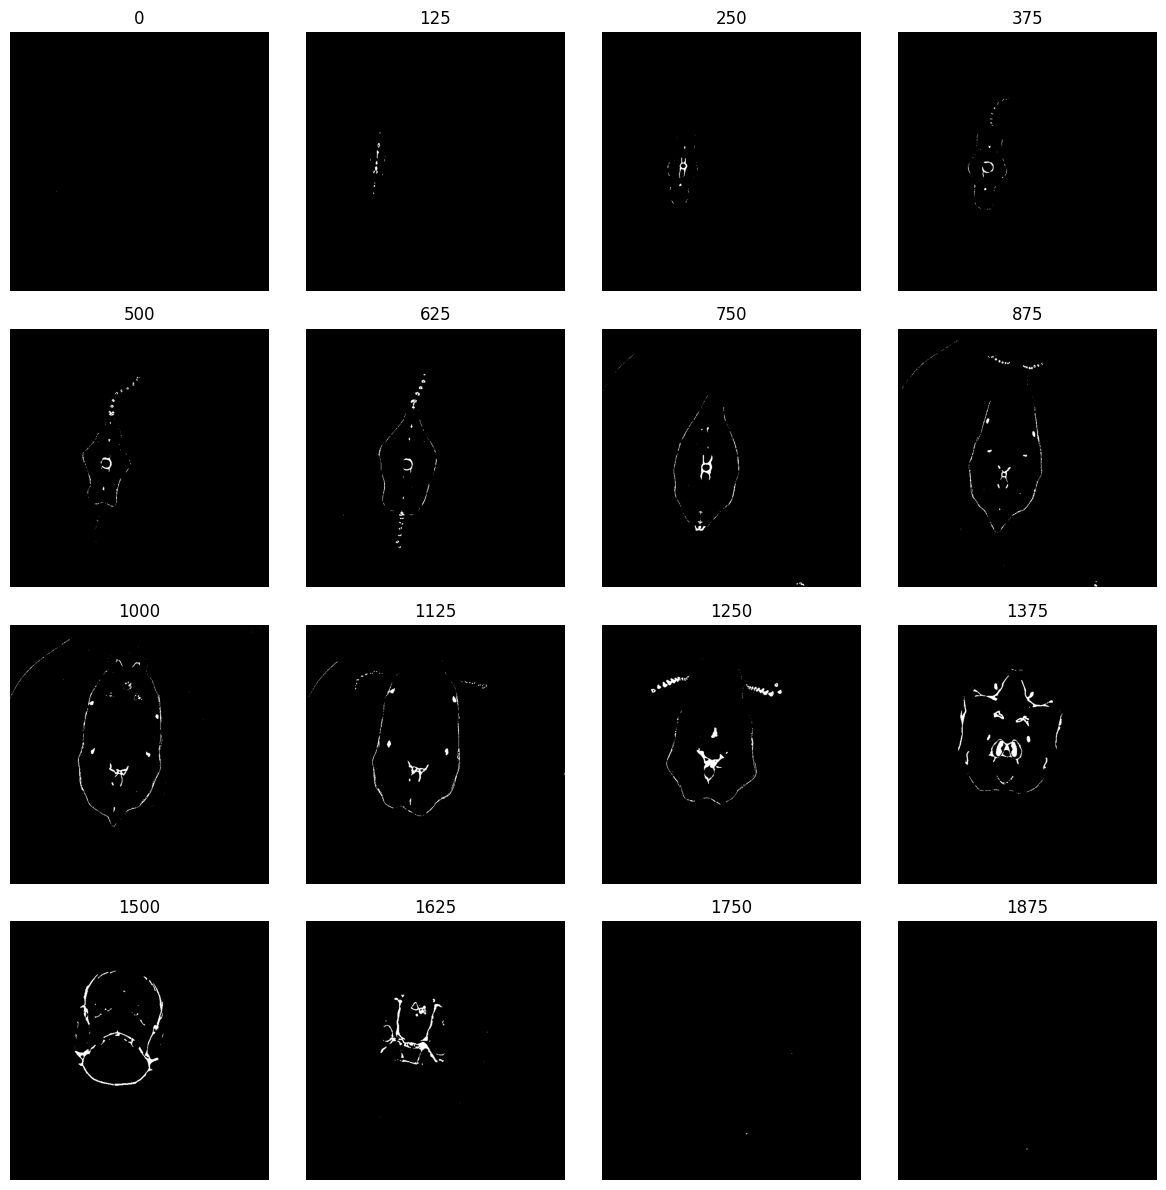

In [20]:
plot.plot_arr(equalised > value)

In [21]:
""" Count the number of pixels in each slice """
n_white = np.sum(equalised > value, axis=(1, 2))

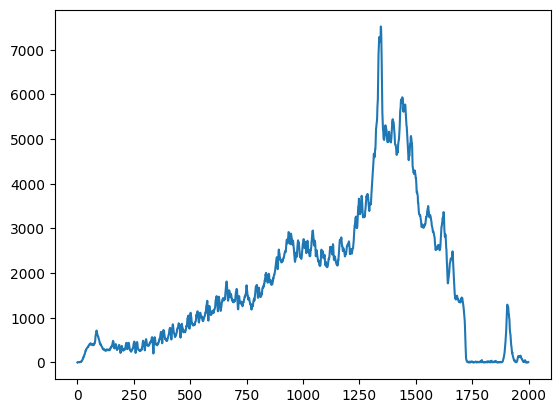

In [22]:
import matplotlib.pyplot as plt

plt.plot(n_white)

100%|██████████| 20/20 [00:18<00:00,  1.09it/s]


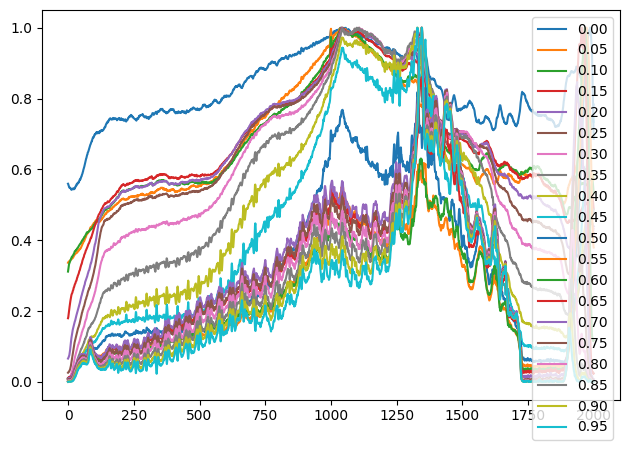

In [17]:
""" Vary the threshold for one image """

from tqdm import tqdm


def n_white(threshold: float) -> np.ndarray:
    return np.sum(equalised > threshold, axis=(1, 2))

x = np.zeros(img.shape[0])
for threshold in tqdm(np.arange(1.0, step=0.05)):
    n = n_white(threshold)

    # Scale to have the same max
    plt.plot(n / np.max(n), label=f"{threshold:.2f}")

    x+= n

plt.legend()

plt.tight_layout()

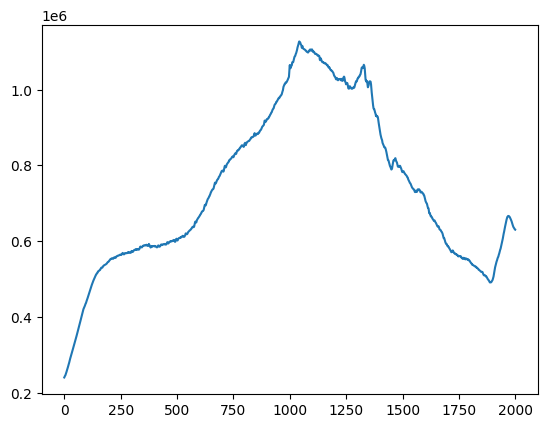

In [18]:
plt.plot(x)

In [23]:
""" Try it for different fish """


def n_white(img: np.ndarray, threshold: float) -> np.ndarray:
    return np.sum(img > threshold, axis=(1, 2))


def profile(img_no: int) -> np.ndarray:
    # Read the image
    img = np.load(f"../tifs/{img_no}.npy")

    # Preprocess
    img = (img - img.min()) / (img.max() - img.min()) * 255
    equalised = thresholding.equalise(img, saturated_pct=saturated_pct)

    # For each threshold, find the number of white pixels at each slice
    x = np.zeros(img.shape[0])
    for threshold in tqdm(np.arange(1.0, step=0.05)):
        n = n_white(equalised, threshold)
        x += n / np.max(n)

    print(f"done {img_no}")
    return x


profiles = [profile(i) for i in [40, 41, 42, 43, 44, 511]]

100%|██████████| 20/20 [00:18<00:00,  1.09it/s]


done 40


100%|██████████| 20/20 [00:18<00:00,  1.07it/s]


done 41


  5%|▌         | 1/20 [00:01<00:28,  1.52s/it]


KeyboardInterrupt: 

In [27]:
from multiprocessing import Pool, Manager

res = Manager().dict()


def f(i):
    res[i] = profile(i)


with Pool(6) as p:
    p.map(f, [40, 41, 42, 43, 44], timeout=60)

res

100%|██████████| 20/20 [00:20<00:00,  1.05s/it]


done 44


100%|██████████| 20/20 [00:21<00:00,  1.08s/it]


done 42


100%|██████████| 20/20 [00:22<00:00,  1.11s/it]


done 41


100%|██████████| 20/20 [00:21<00:00,  1.07s/it]


done 40


KeyboardInterrupt: 

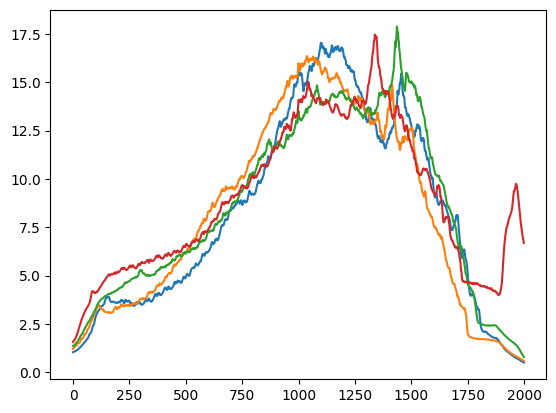

In [30]:
for i, v in res.items():
    plt.plot(v, label=i)

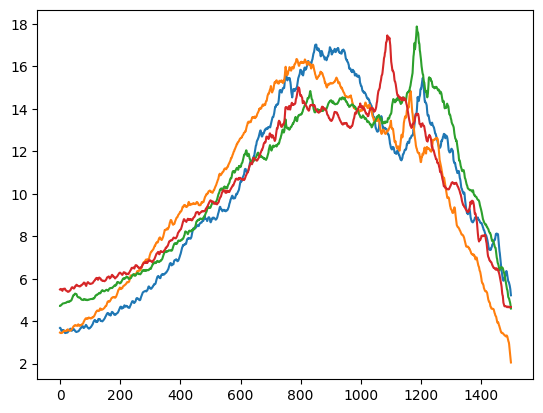

In [31]:
""" We can assume the head won't be in the first or last 250 slices """

for i, v in res.items():
    plt.plot(v[250:-250], label=i)

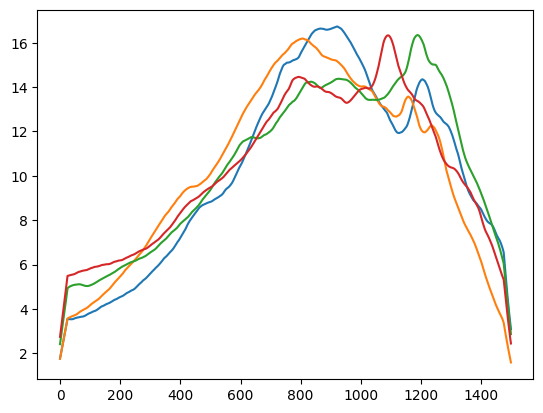

In [67]:
""" Smooth """

n = 50
tophat = np.ones(n) / n

smoothed = {i: np.convolve(v[250:-250], tophat, mode="same") for i, v in res.items()}

for i, v in smoothed.items():
    plt.plot(v, label=i)

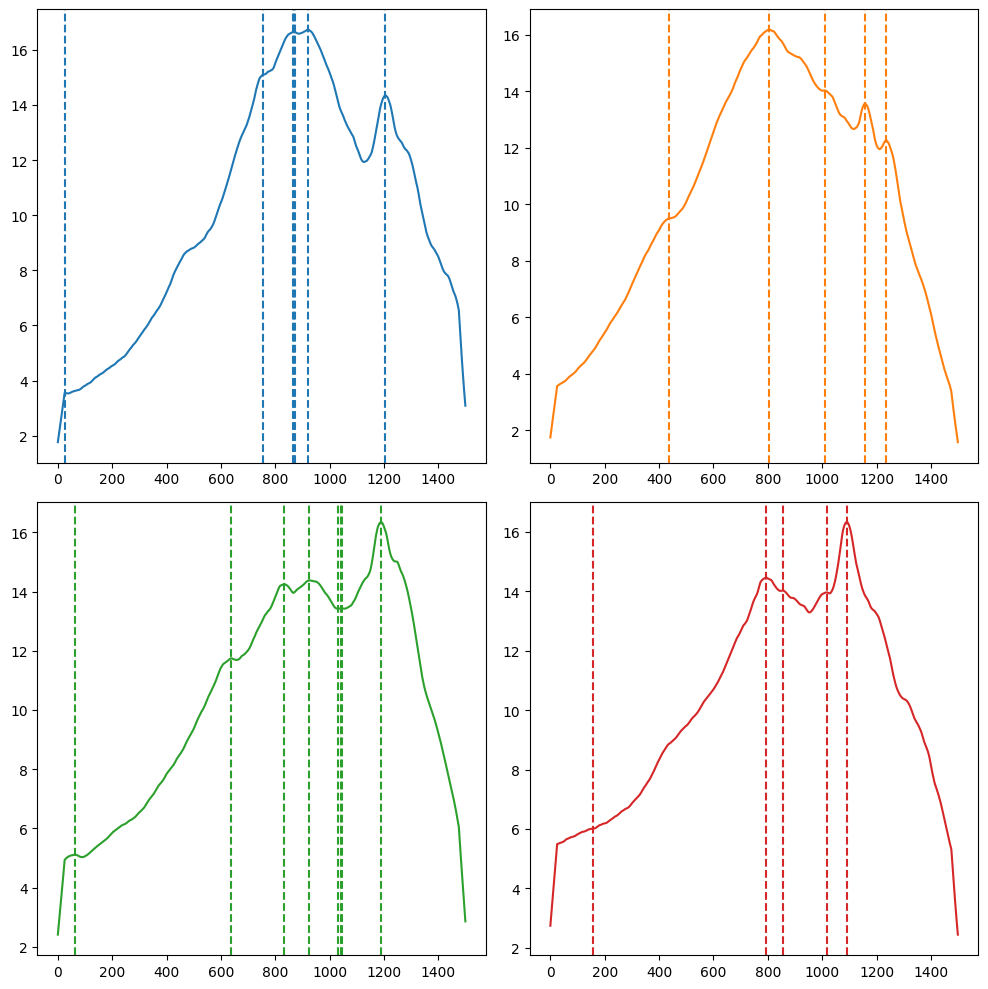

In [78]:
""" Find peaks """

from scipy.signal import find_peaks

peaks = {i: find_peaks(v, height=0.5)[0] for i, v in smoothed.items()}

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

for j, ((i, v), axis) in enumerate(zip(smoothed.items(), axes.flat)):
    axis.plot(v, label=i, color=f"C{j}")
    for peak in peaks[i]:
        axis.axvline(peak, color=f"C{j}", linestyle="--")

fig.tight_layout()